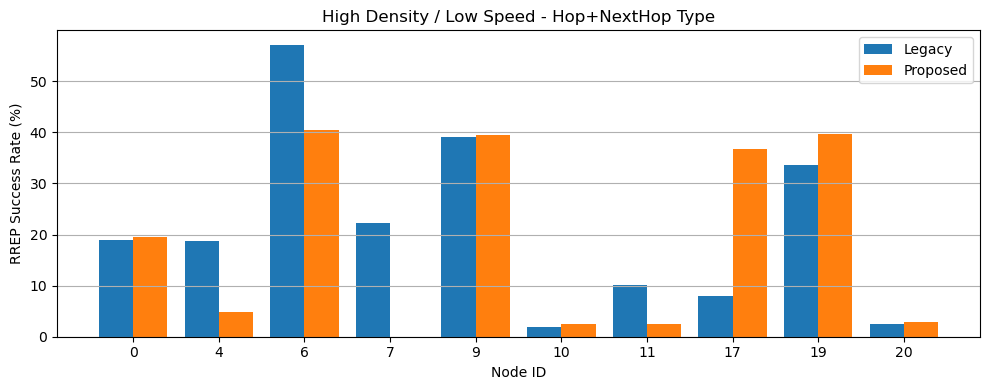

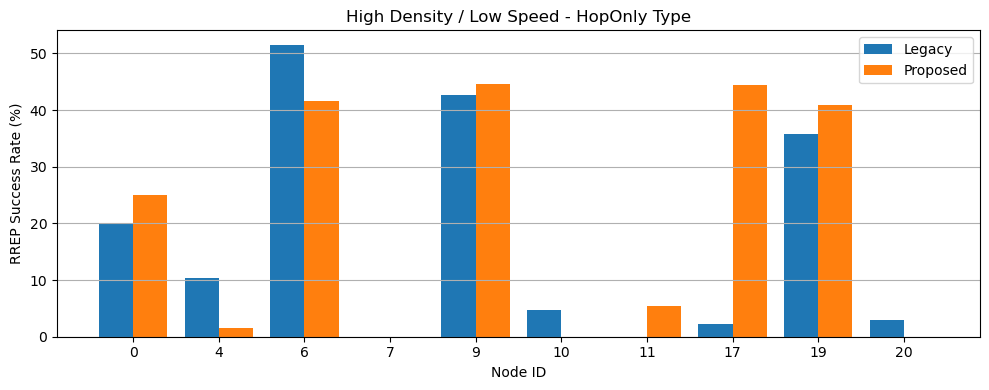

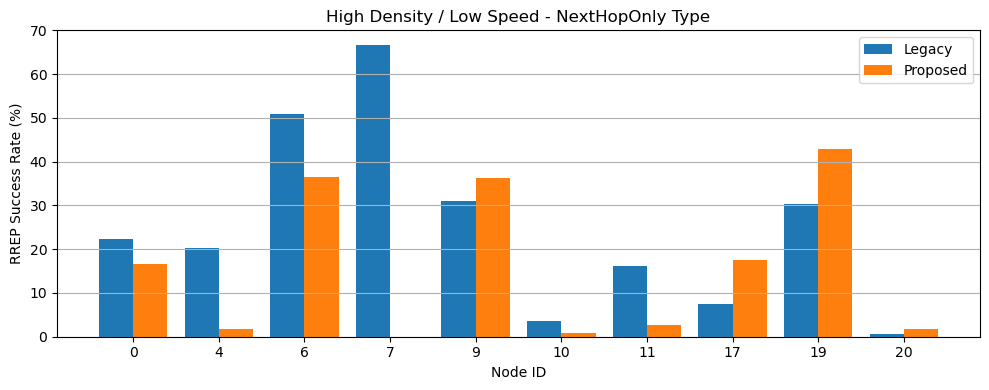

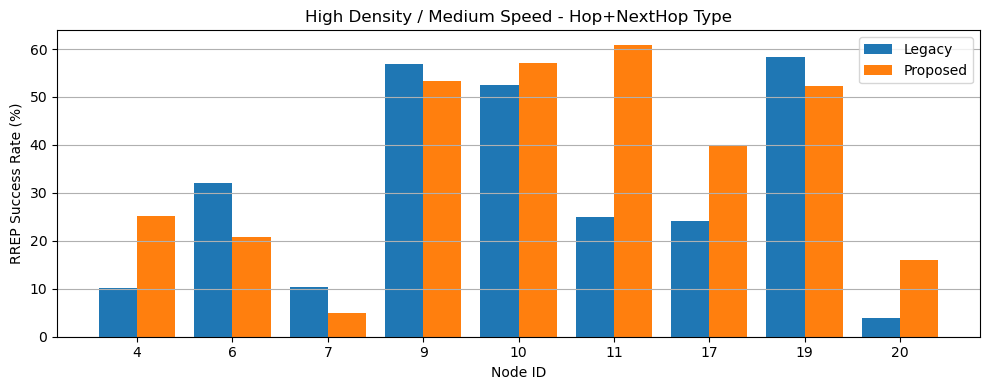

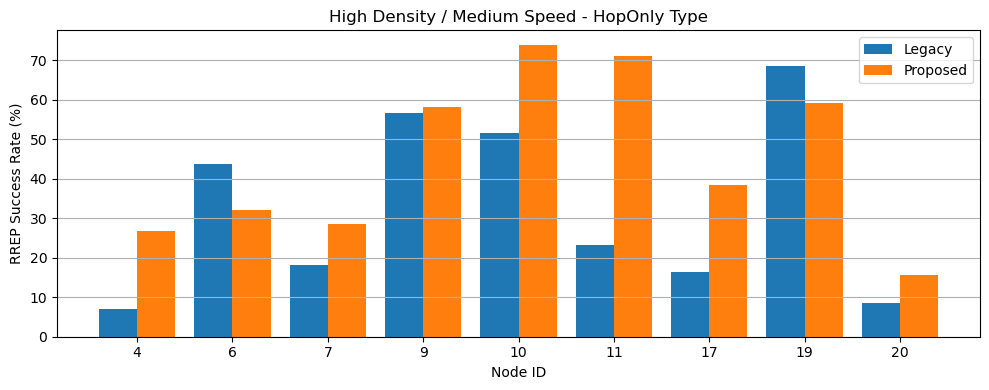

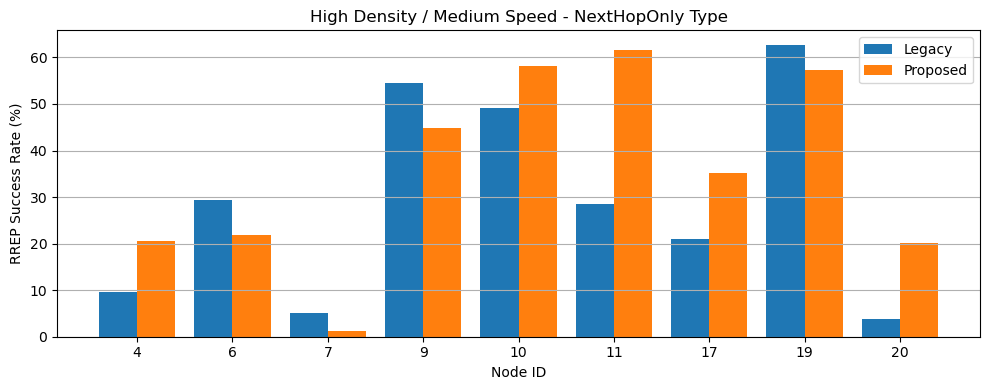

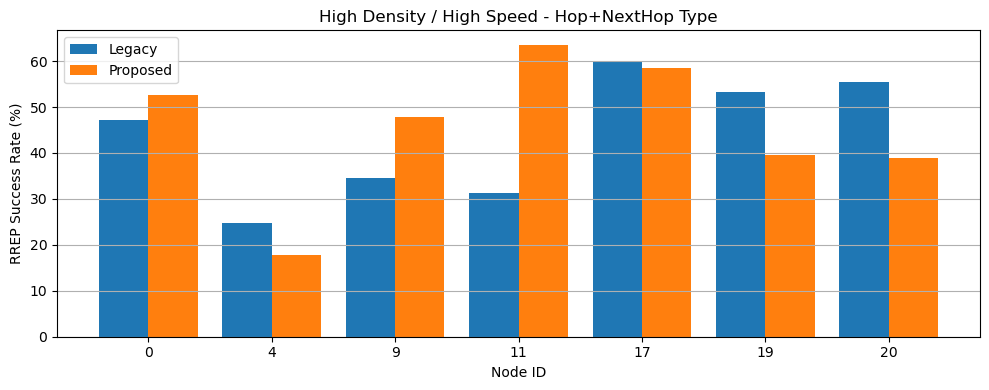

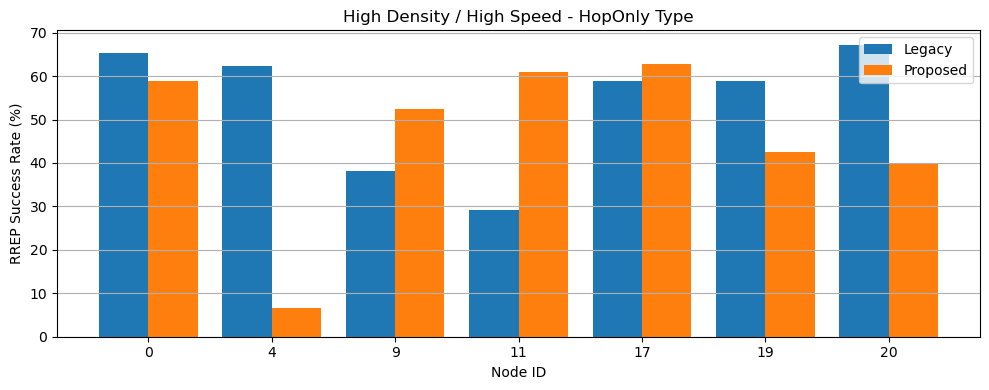

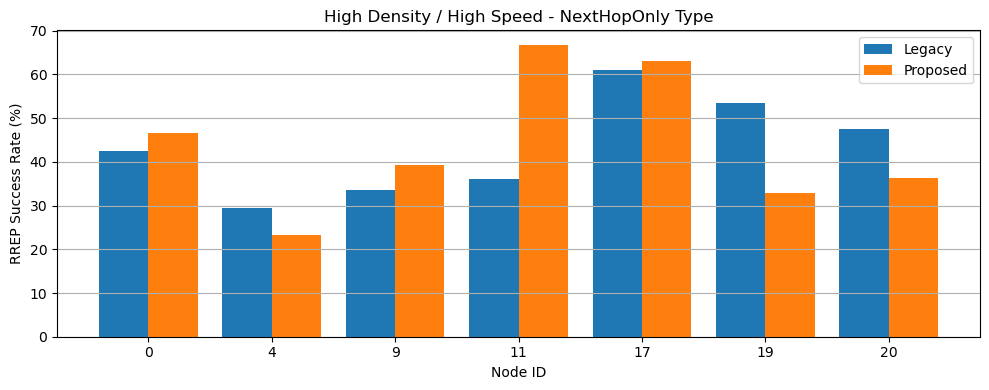

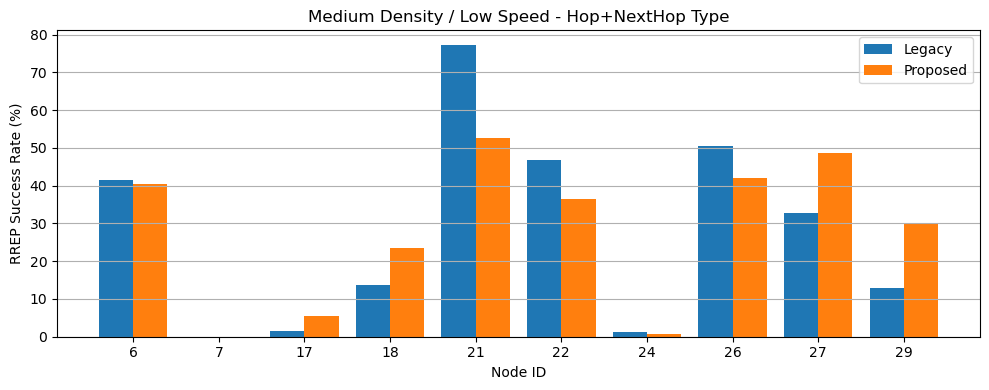

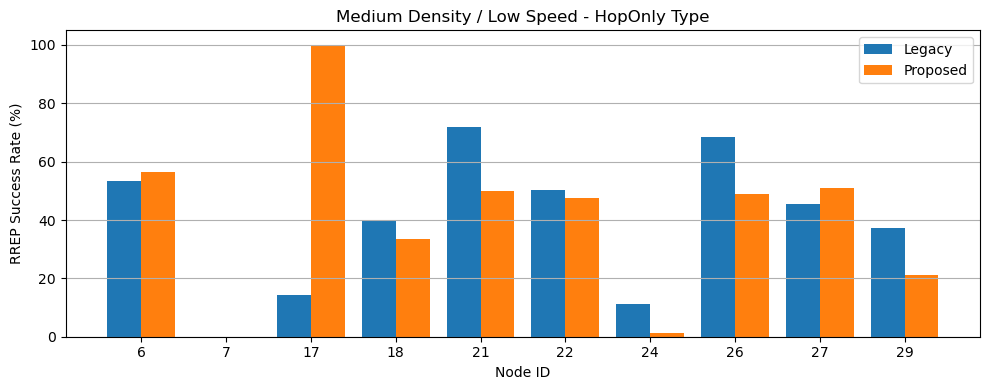

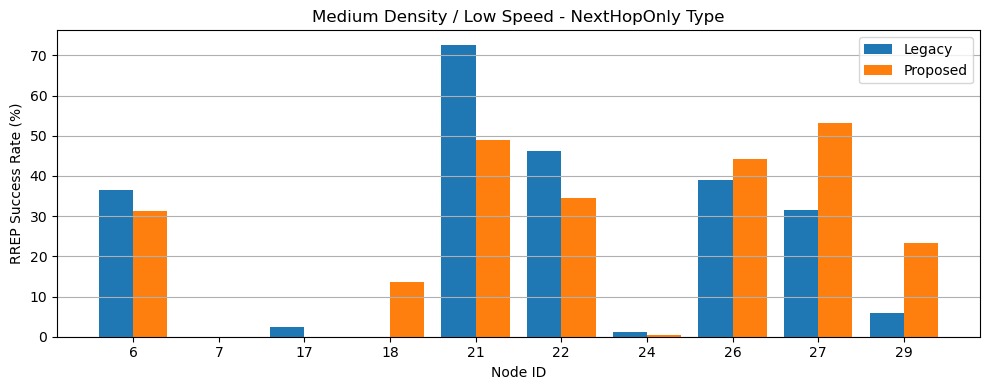

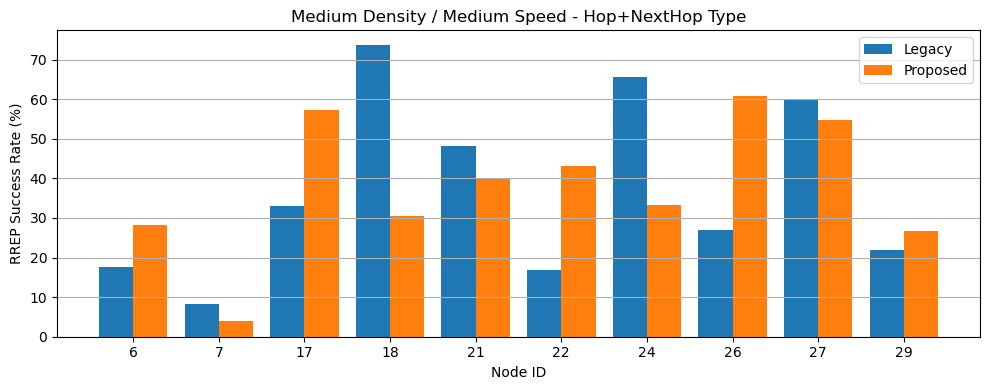

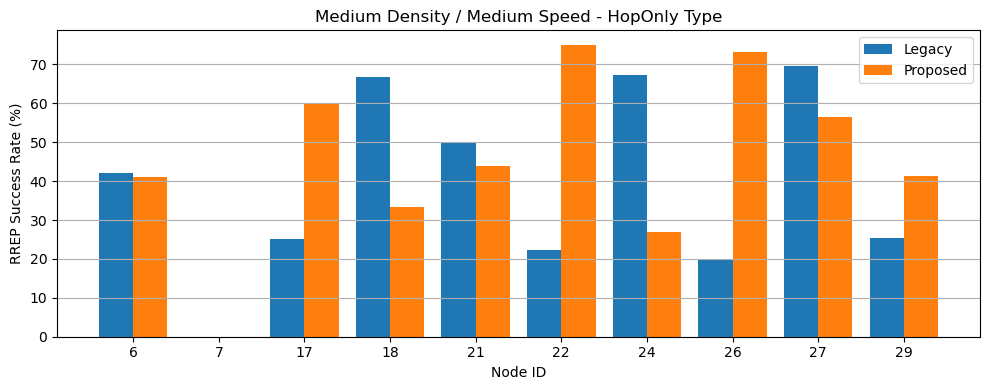

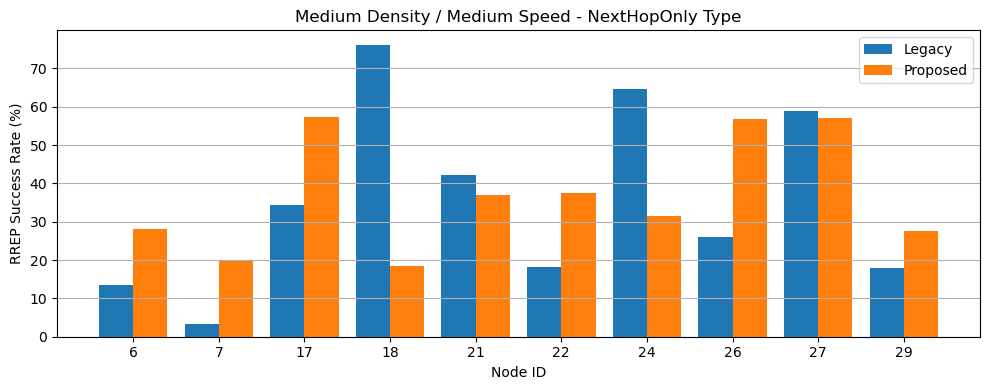

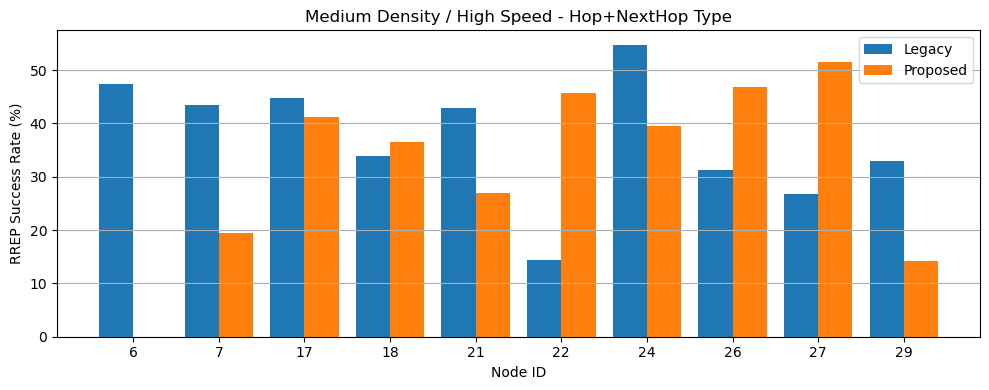

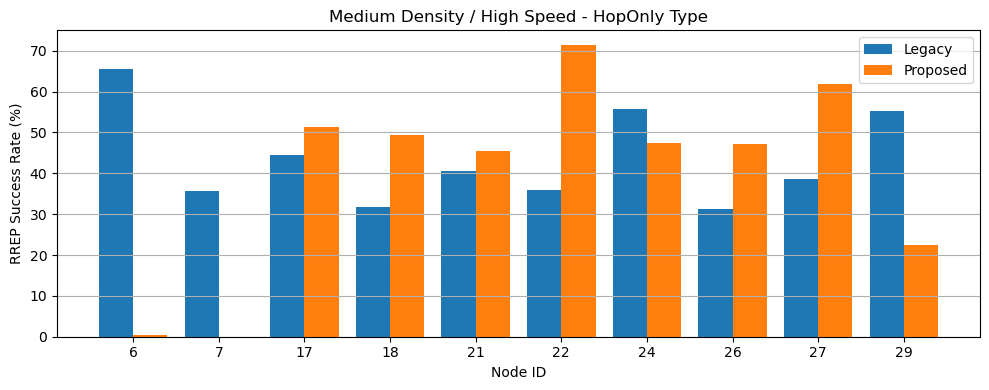

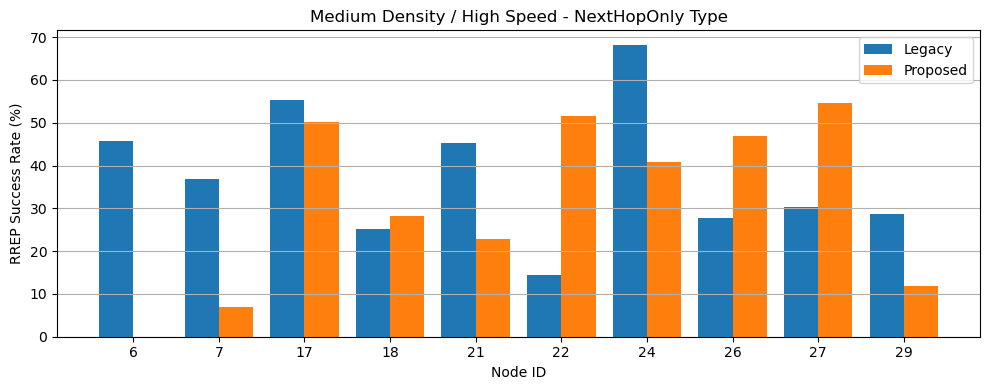

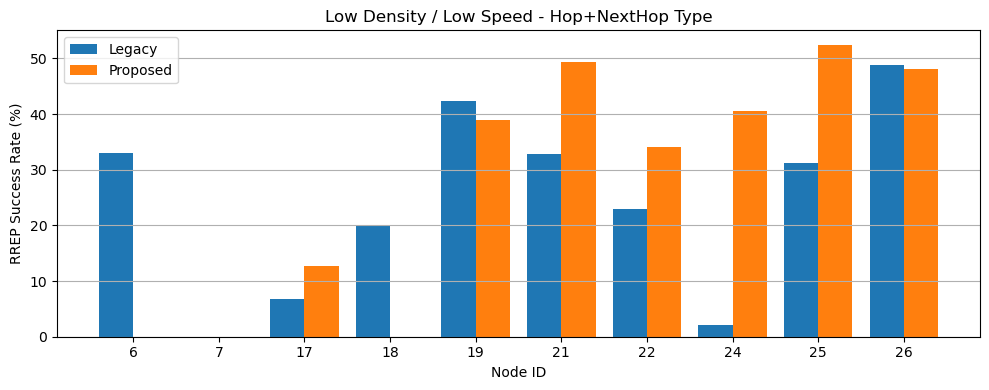

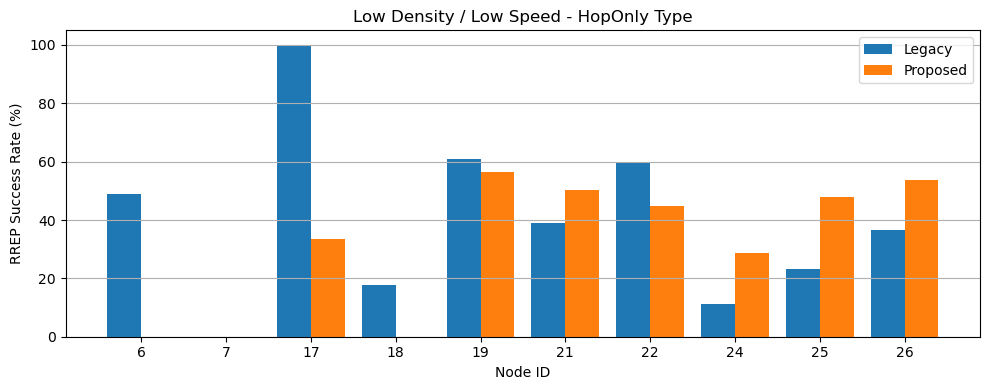

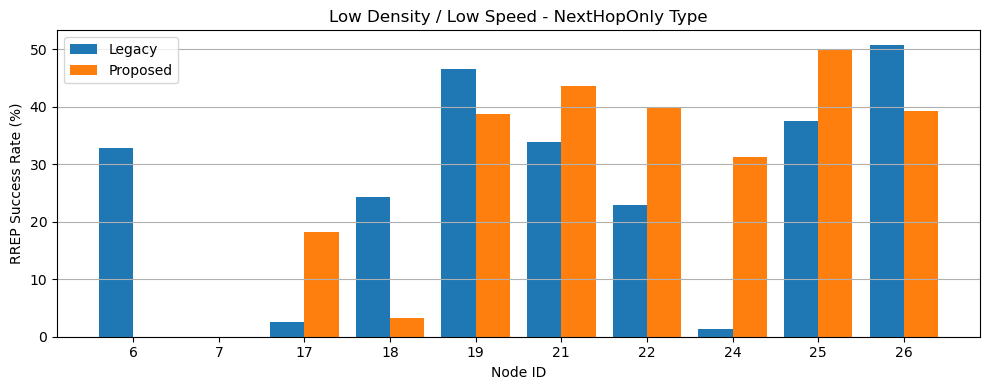

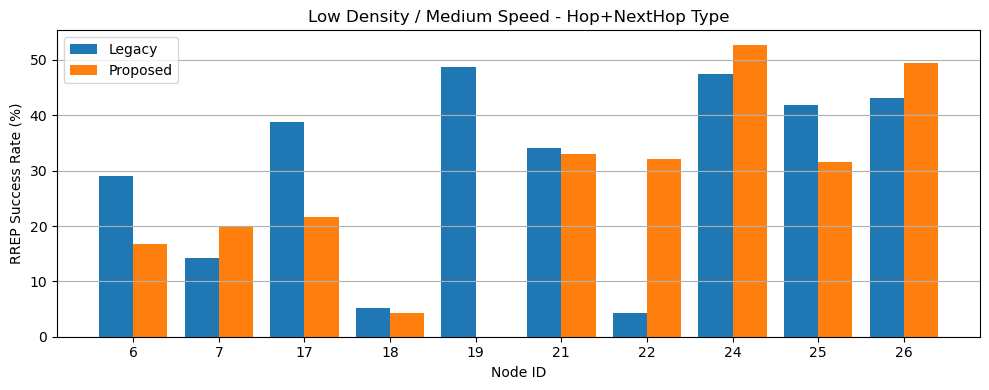

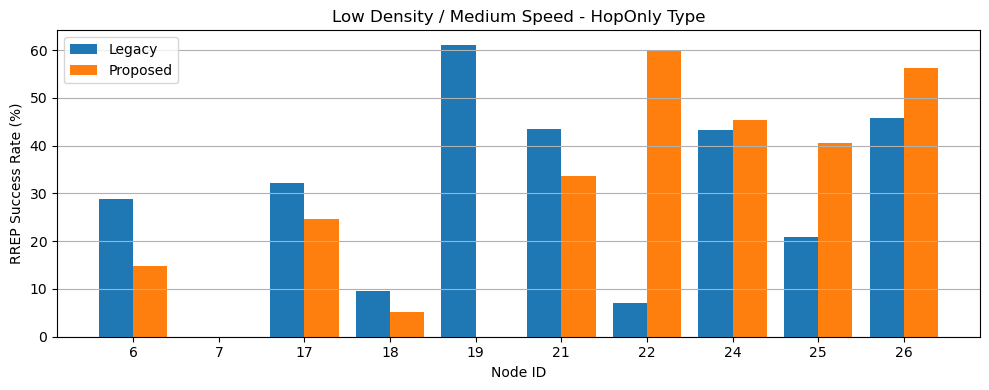

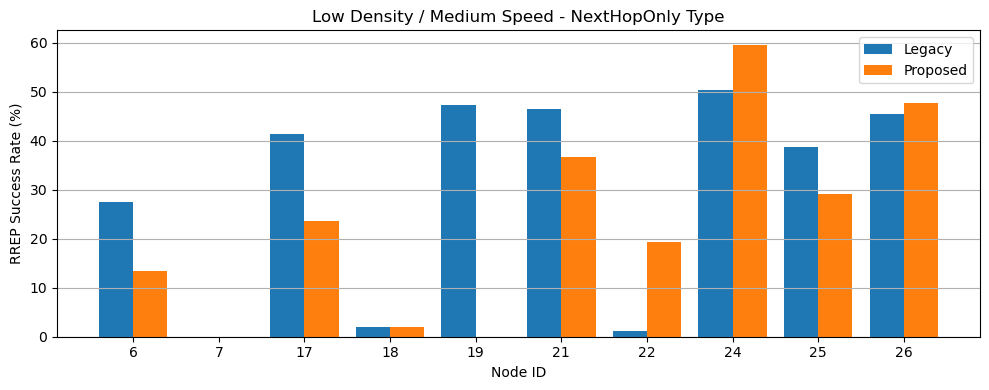

C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_37276\2262266891.py:29: DtypeWarning: Columns (0,3,4,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


TypeError: '<' not supported between instances of 'float' and 'str'

In [3]:
import os
import bisect
import pandas as pd
import matplotlib.pyplot as plt

change_types = ["Hop+NextHop", "HopOnly", "NextHopOnly"]
density_levels = ["고밀도", "중밀도", "저밀도"]
speed_levels = ["저속", "중속", "고속"]
interval = 3.0

density_map = {"고밀도": "High", "중밀도": "Medium", "저밀도": "Low"}
speed_map = {"저속": "Low", "중속": "Medium", "고속": "High"}

node_dict = {
    ("고밀도", "저속"): [0, 4, 6, 7, 9, 10, 11, 17, 19, 20],
    ("고밀도", "중속"): [0, 4, 6, 7, 9, 10, 11, 17, 19, 20],
    ("고밀도", "고속"): [0, 4, 6, 7, 9, 10, 11, 17, 19, 20],
    ("중밀도", "저속"): [6, 7, 17, 18, 21, 22, 24, 26, 27, 29],
    ("중밀도", "중속"): [6, 7, 17, 18, 21, 22, 24, 26, 27, 29],
    ("중밀도", "고속"): [6, 7, 17, 18, 21, 22, 24, 26, 27, 29],
    ("저밀도", "저속"): [6, 7, 17, 18, 19, 21, 22, 24, 25, 26],
    ("저밀도", "중속"): [6, 7, 17, 18, 19, 21, 22, 24, 25, 26],
    ("저밀도", "고속"): [6, 7, 17, 18, 19, 21, 22, 24, 25, 26],
}

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/"

def load_and_classify_routing_log(path):
    df = pd.read_csv(path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["ChangeType"] = df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else None,
        axis=1
    )
    return df

def estimate_rrep_success_rate(routing_log_path, recovery_log_path, change_type, interval):
    if not os.path.exists(routing_log_path) or not os.path.exists(recovery_log_path):
        return None

    df = load_and_classify_routing_log(routing_log_path)
    df = df[df["ChangeType"] == change_type][["Time", "Destination"]].copy()
    df["Destination"] = df["Destination"].astype(str)

    if df.empty:
        return 0.0

    recovery_df = pd.read_csv(recovery_log_path, header=None, names=["Time", "Node", "Destination", "Event"])
    rrep_df = recovery_df[recovery_df["Event"] == "RREP_RECV"][["Time", "Destination"]].copy()
    rrep_df["Destination"] = rrep_df["Destination"].astype(str)

    rrep_dict = {}
    for dest, group in rrep_df.groupby("Destination"):
        rrep_dict[dest] = sorted(group["Time"].tolist())

    total = len(df)
    success = 0

    for _, row in df.iterrows():
        t = row["Time"]
        d = row["Destination"]
        if d not in rrep_dict:
            continue
        times = rrep_dict[d]
        idx = bisect.bisect_left(times, t)
        if idx < len(times) and times[idx] <= t + interval:
            success += 1

    return (success / total) * 100 if total > 0 else 0.0

for density in density_levels:
    for speed in speed_levels:
        node_list = node_dict.get((density, speed), [])
        if not node_list:
            continue

        for change in change_types:
            legacy_rates = []
            proposed_rates = []
            valid_nodes = []

            for node_id in node_list:
                legacy_routing = os.path.join(base_path, density, speed, "기존", str(node_id), "aodv_routing_log.csv")
                legacy_recovery = os.path.join(base_path, density, speed, "기존", str(node_id), "recovery_log.csv")
                proposed_routing = os.path.join(base_path, density, speed, "제안", str(node_id), "aodv_routing_log.csv")
                proposed_recovery = os.path.join(base_path, density, speed, "제안", str(node_id), "recovery_log.csv")

                legacy_rate = estimate_rrep_success_rate(legacy_routing, legacy_recovery, change, interval)
                proposed_rate = estimate_rrep_success_rate(proposed_routing, proposed_recovery, change, interval)

                if legacy_rate is not None and proposed_rate is not None:
                    legacy_rates.append(legacy_rate)
                    proposed_rates.append(proposed_rate)
                    valid_nodes.append(node_id)

            if not valid_nodes:
                continue

            x = range(len(valid_nodes))
            d_label = density_map.get(density, density)
            s_label = speed_map.get(speed, speed)

            plt.figure(figsize=(10, 4))
            plt.bar([i - 0.2 for i in x], legacy_rates, width=0.4, label="Legacy")
            plt.bar([i + 0.2 for i in x], proposed_rates, width=0.4, label="Proposed")
            plt.xticks(x, [str(n) for n in valid_nodes])
            plt.xlabel("Node ID")
            plt.ylabel("RREP Success Rate (%)")
            plt.title(f"{d_label} Density / {s_label} Speed - {change} Type")
            plt.legend()
            plt.grid(True, axis='y')
            plt.tight_layout()
            plt.show()


In [7]:
import os
import bisect
import pandas as pd
import matplotlib.pyplot as plt

xnodes = [0, 4, 6, 7, 9, 10, 11, 17, 19, 20]
nodes = [6, 7, 17, 18, 19, 21, 22, 24, 25, 26]

change_types = ["Hop+NextHop", "HopOnly", "NextHopOnly"]
interval = 3.0

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/저밀도/고속/"

def load_and_classify_routing_log(path):
    df = pd.read_csv(path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["LifeTimeChange"] = df["Previous_LifeTime"] != df["New_LifeTime"]
    df["ChangeType"] = df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange",
        axis=1
    )
    return df

def estimate_rrep_success_rate(routing_log_path, recovery_log_path, change_type, interval):
    if not os.path.exists(routing_log_path) or not os.path.exists(recovery_log_path):
        return None

    df = load_and_classify_routing_log(routing_log_path)
    df = df[df["ChangeType"] == change_type][["Time", "Destination"]].copy()
    df["Destination"] = df["Destination"].astype(str)

    if df.empty:
        return 0.0

    recovery_df = pd.read_csv(recovery_log_path, header=None, names=["Time", "Node", "Destination", "Event"])
    rrep_df = recovery_df[recovery_df["Event"] == "RREP_RECV"][["Time", "Destination"]].copy()
    rrep_df["Destination"] = rrep_df["Destination"].astype(str)

    rrep_dict = {}
    for dest, group in rrep_df.groupby("Destination"):
        rrep_dict[dest] = sorted([float(t) for t in group["Time"].tolist()])

    total = len(df)
    success = 0

    for _, row in df.iterrows():
        t = row["Time"]
        d = row["Destination"]
        if d not in rrep_dict:
            continue
        times = rrep_dict[d]
        idx = bisect.bisect_left(times, t)
        if idx < len(times) and times[idx] <= t + interval:
            success += 1

    return (success / total) * 100 if total > 0 else 0.0

results = {change: [] for change in change_types}
valid_nodes = []

for node_id in nodes:
    legacy_routing = os.path.join(base_path, "기존", str(node_id), "aodv_routing_log.csv")
    legacy_recovery = os.path.join(base_path, "기존", str(node_id), "recovery_log.csv")
    proposed_routing = os.path.join(base_path, "제안", str(node_id), "aodv_routing_log.csv")
    proposed_recovery = os.path.join(base_path, "제안", str(node_id), "recovery_log.csv")

    if not all(map(os.path.exists, [legacy_routing, legacy_recovery, proposed_routing, proposed_recovery])):
        continue

    valid_nodes.append(node_id)

    for change in change_types:
        legacy_rate = estimate_rrep_success_rate(legacy_routing, legacy_recovery, change, interval)
        proposed_rate = estimate_rrep_success_rate(proposed_routing, proposed_recovery, change, interval)
        results[change].append((legacy_rate, proposed_rate))

for change in change_types:
    if change not in results or not results[change]:
        continue

    legacy_rates, proposed_rates = zip(*results[change])
    x = range(len(valid_nodes))
    plt.figure()
    plt.bar([i - 0.2 for i in x], legacy_rates, width=0.4, label="Legacy")
    plt.bar([i + 0.2 for i in x], proposed_rates, width=0.4, label="Proposed")
    plt.xticks(x, [str(n) for n in valid_nodes])
    plt.xlabel("Node ID")
    plt.ylabel("RREP Success Rate (%)")
    plt.title(f"RREP Success Rate by Node ({change})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_37276\1753763708.py:15: DtypeWarning: Columns (0,3,4,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


TypeError: '<' not supported between instances of 'float' and 'str'

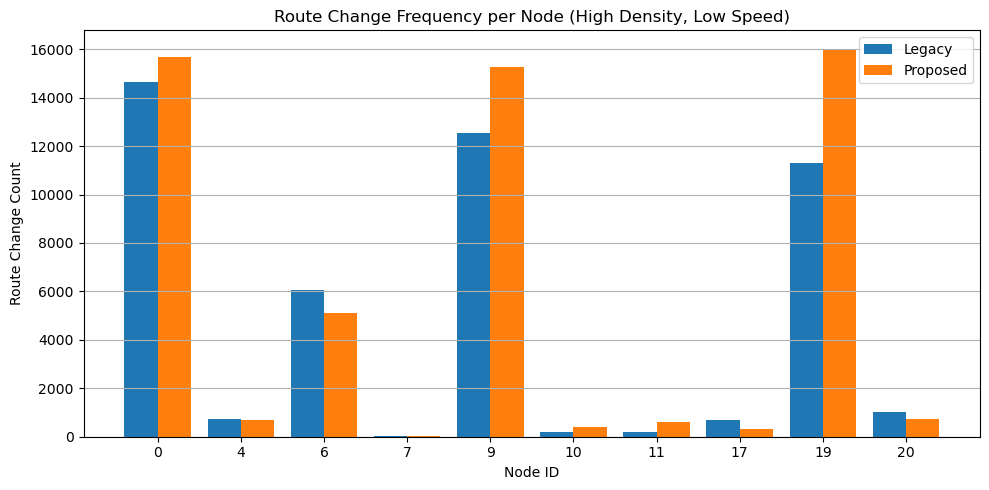

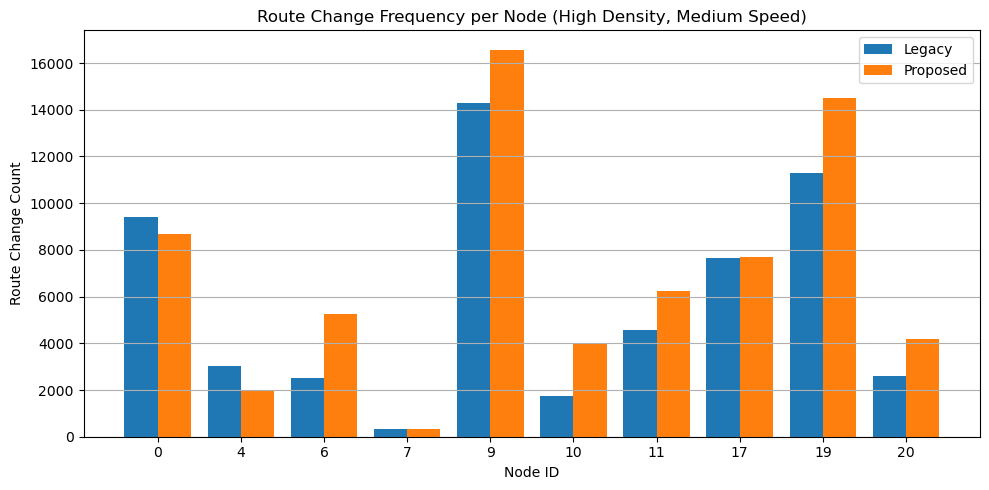

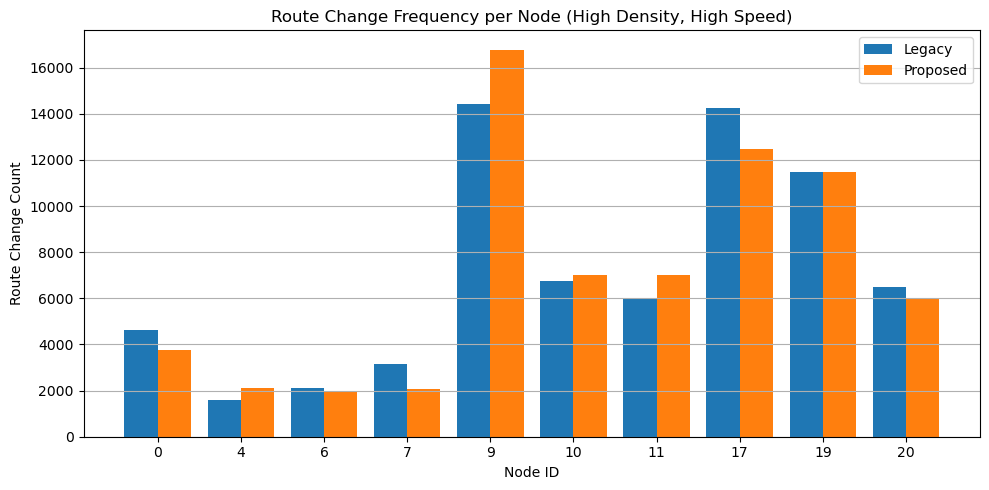

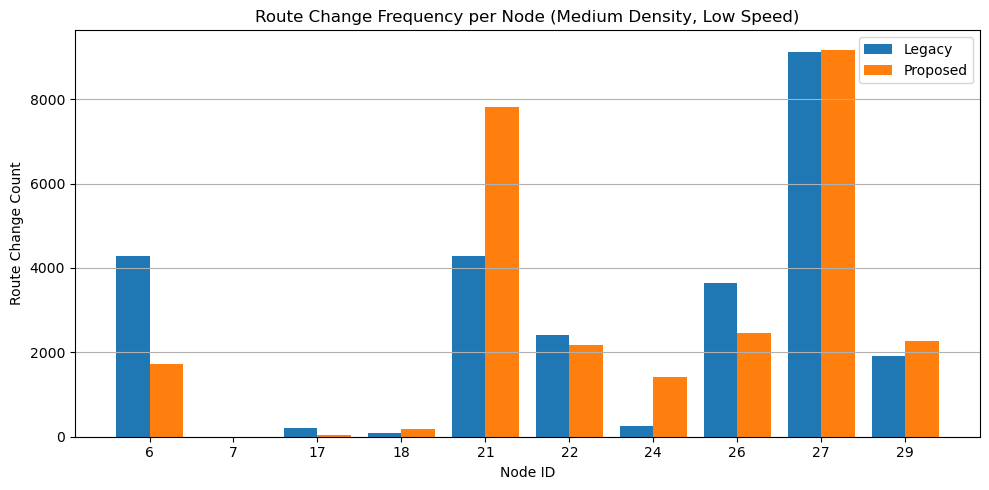

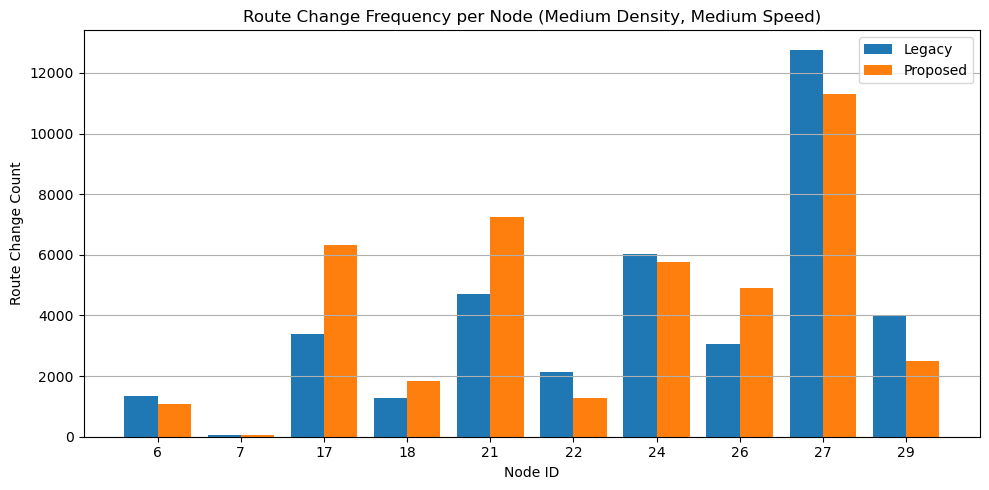

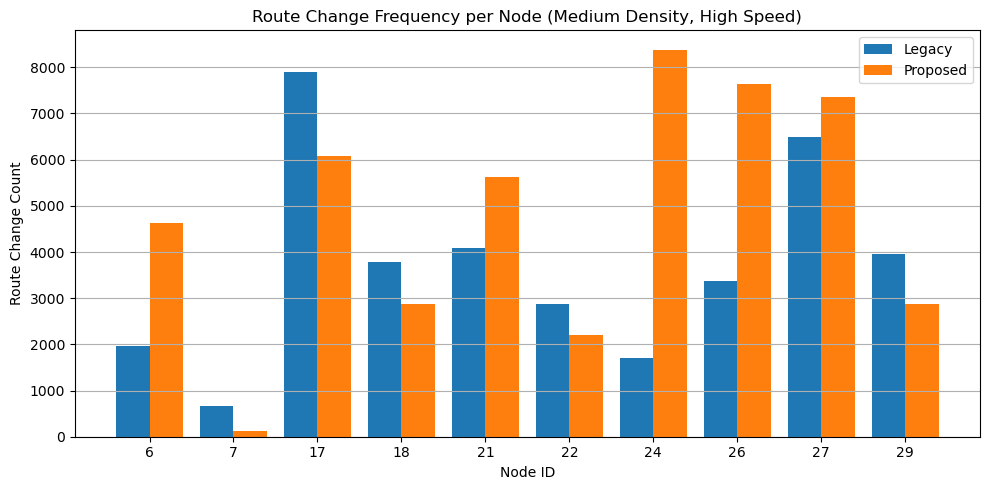

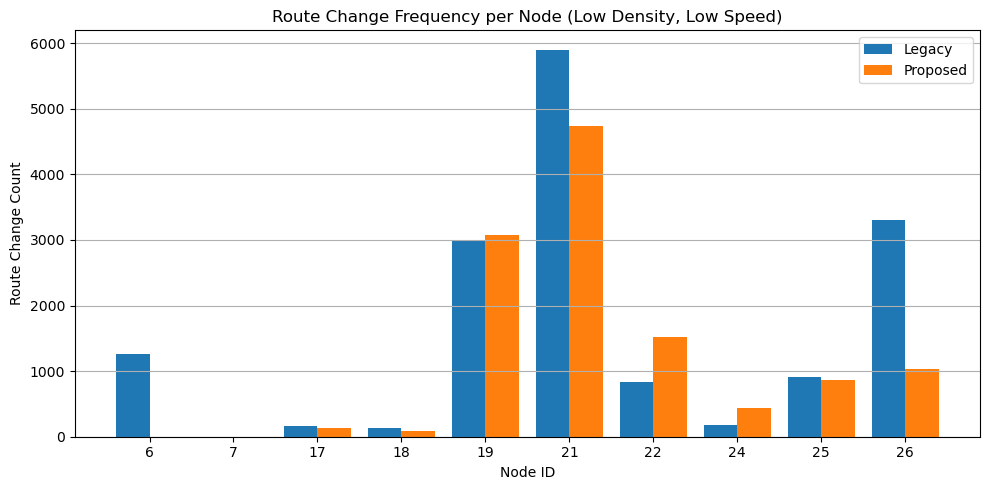

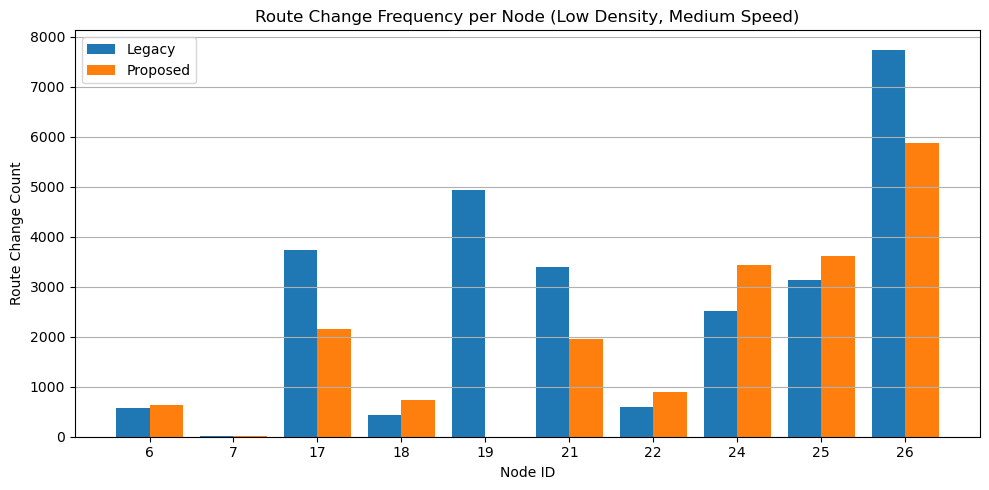

C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_37292\75132423.py:28: DtypeWarning: Columns (0,3,4,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


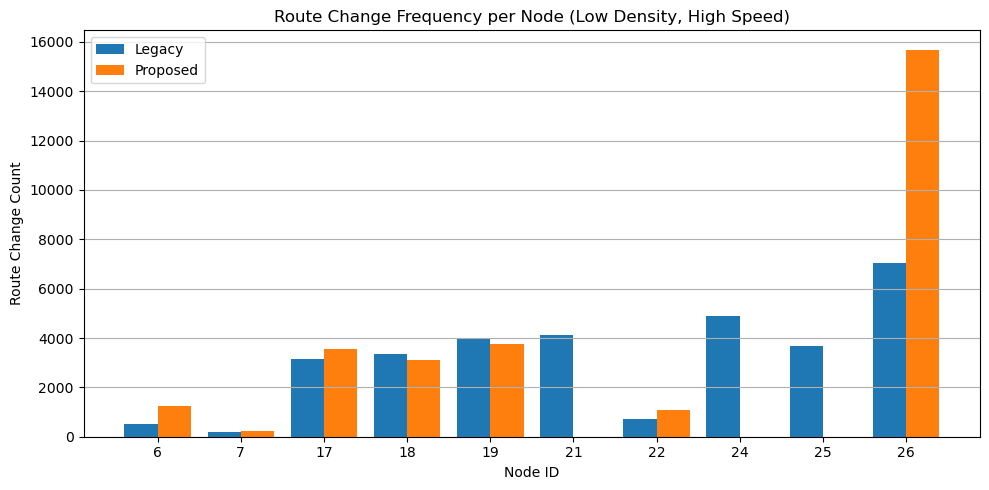

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

density_levels = ["고밀도", "중밀도", "저밀도"]
speed_levels = ["저속", "중속", "고속"]

density_map = {"고밀도": "High", "중밀도": "Medium", "저밀도": "Low"}
speed_map = {"저속": "Low", "중속": "Medium", "고속": "High"}

node_dict = {
    ("고밀도", "저속"): [0, 4, 6, 7, 9, 10, 11, 17, 19, 20],
    ("고밀도", "중속"): [0, 4, 6, 7, 9, 10, 11, 17, 19, 20],
    ("고밀도", "고속"): [0, 4, 6, 7, 9, 10, 11, 17, 19, 20],
    ("중밀도", "저속"): [6, 7, 17, 18, 21, 22, 24, 26, 27, 29],
    ("중밀도", "중속"): [6, 7, 17, 18, 21, 22, 24, 26, 27, 29],
    ("중밀도", "고속"): [6, 7, 17, 18, 21, 22, 24, 26, 27, 29],
    ("저밀도", "저속"): [6, 7, 17, 18, 19, 21, 22, 24, 25, 26],
    ("저밀도", "중속"): [6, 7, 17, 18, 19, 21, 22, 24, 25, 26],
    ("저밀도", "고속"): [6, 7, 17, 18, 19, 21, 22, 24, 25, 26],
}

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02"

def count_route_changes(path):
    try:
        df = pd.read_csv(path)
        df.columns = [
            "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
            "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
        ]
    except Exception:
        return None

    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["RouteChange"] = df["HopChange"] | df["NextHopChange"]
    return df["RouteChange"].sum()

for density in density_levels:
    for speed in speed_levels:
        node_list = node_dict.get((density, speed), [])
        if not node_list:
            continue

        legacy_counts = []
        proposed_counts = []
        valid_nodes = []

        for node_id in node_list:
            legacy_path = os.path.join(base_path, density, speed, "기존", str(node_id), "aodv_routing_log.csv")
            proposed_path = os.path.join(base_path, density, speed, "제안", str(node_id), "aodv_routing_log.csv")

            if not os.path.exists(legacy_path) or not os.path.exists(proposed_path):
                continue

            legacy_count = count_route_changes(legacy_path)
            proposed_count = count_route_changes(proposed_path)

            if legacy_count is None or proposed_count is None:
                continue

            legacy_counts.append(legacy_count)
            proposed_counts.append(proposed_count)
            valid_nodes.append(node_id)

        if not valid_nodes:
            continue

        x = np.arange(len(valid_nodes))
        d_label = density_map[density]
        s_label = speed_map[speed]

        plt.figure(figsize=(10, 5))
        plt.bar(x - 0.2, legacy_counts, width=0.4, label='Legacy')
        plt.bar(x + 0.2, proposed_counts, width=0.4, label='Proposed')

        plt.xticks(x, [str(n) for n in valid_nodes])
        plt.xlabel("Node ID")
        plt.ylabel("Route Change Count")
        plt.title(f"Route Change Frequency per Node ({d_label} Density, {s_label} Speed)")
        plt.legend()
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()


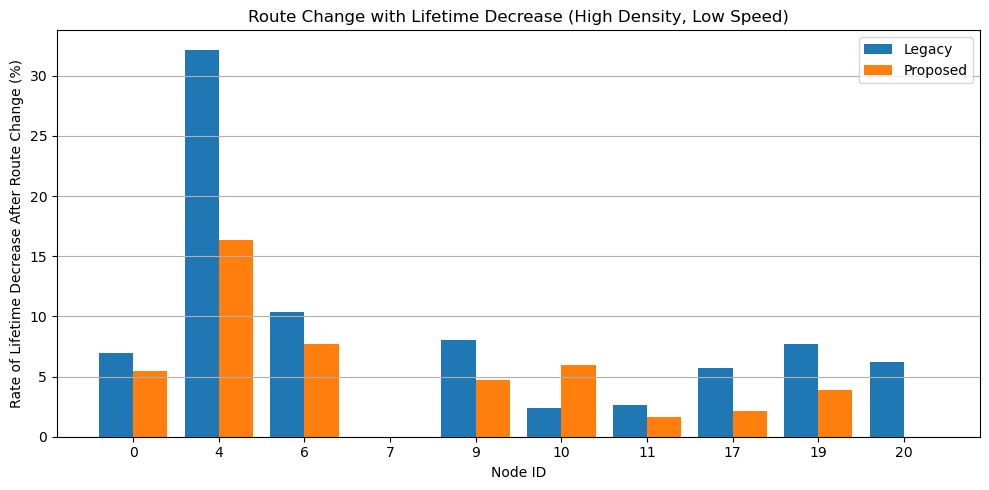

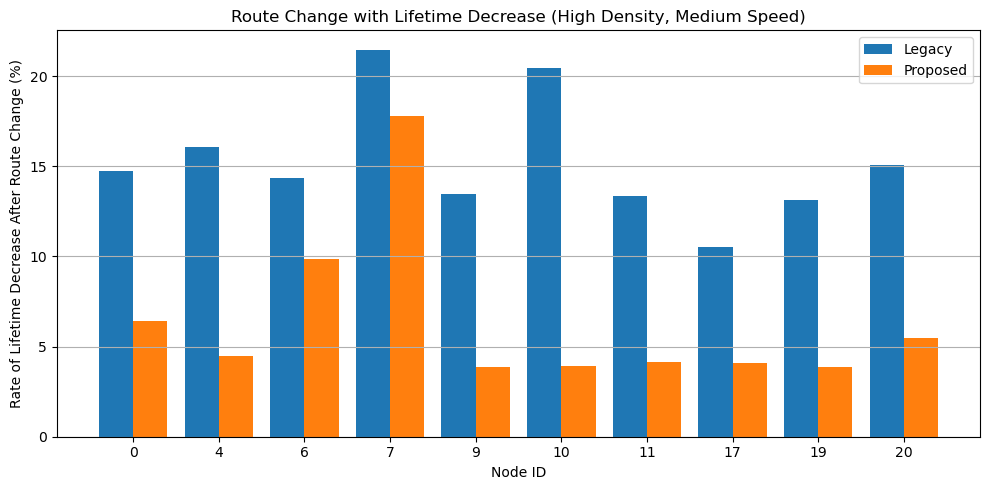

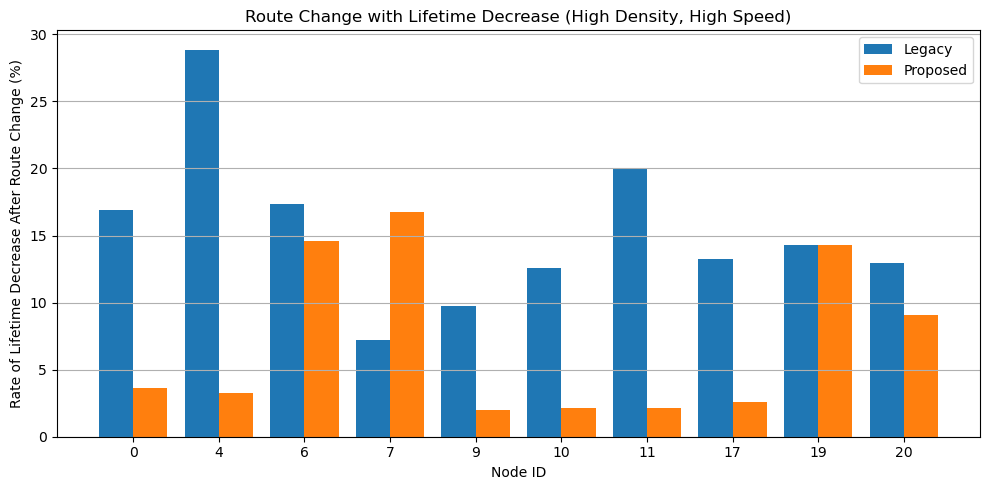

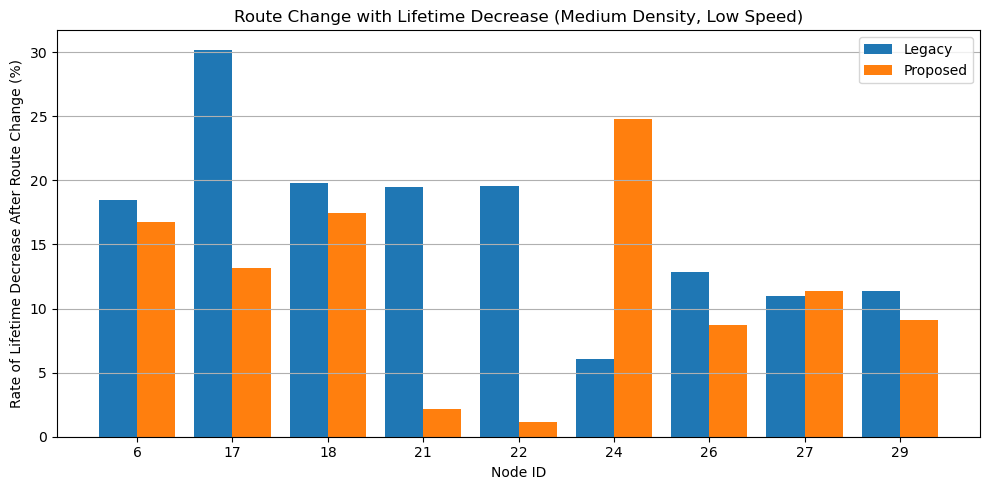

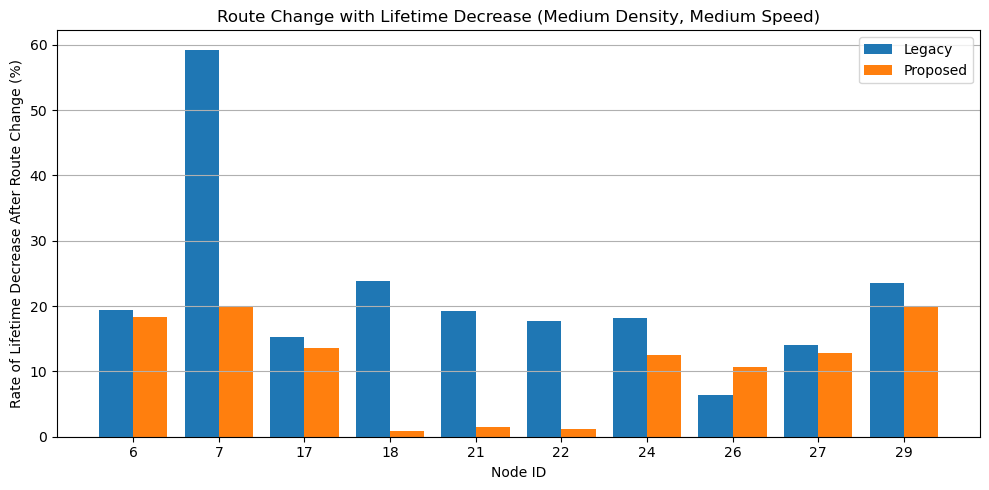

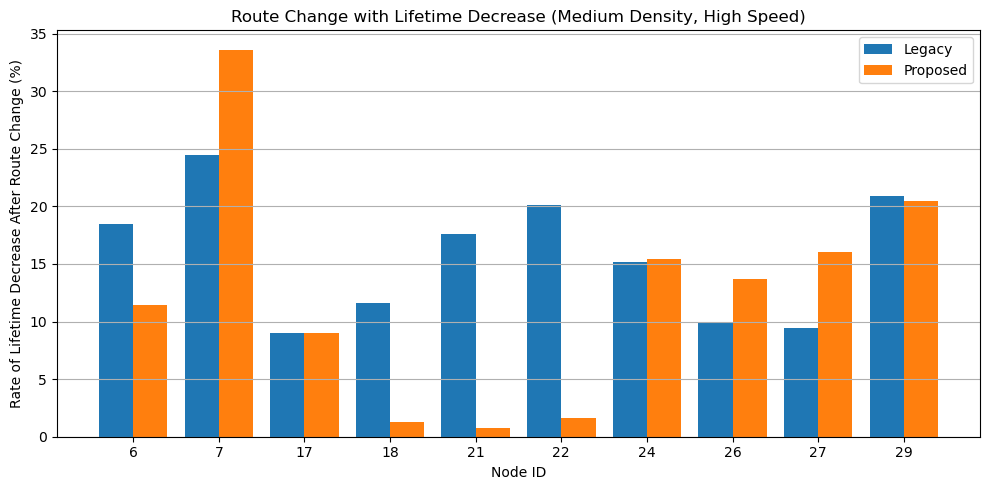

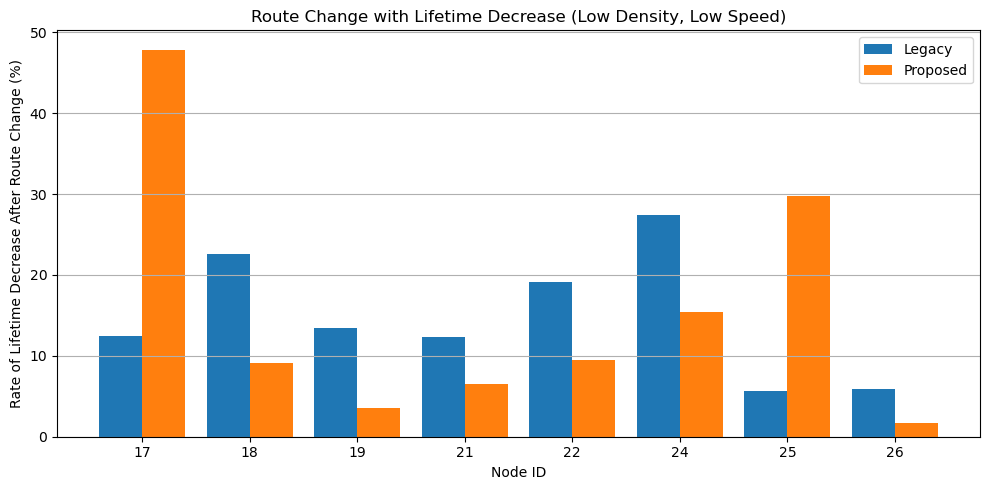

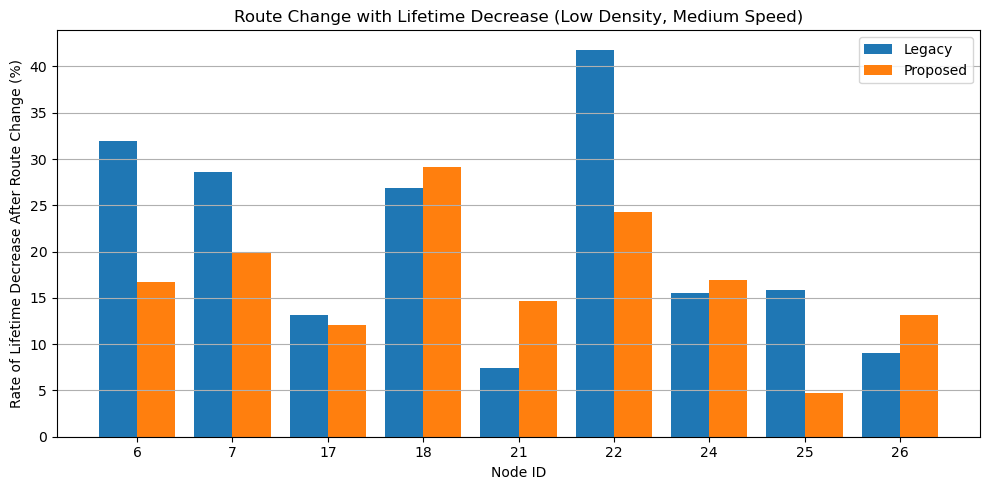

C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_37292\3090358923.py:28: DtypeWarning: Columns (0,3,4,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


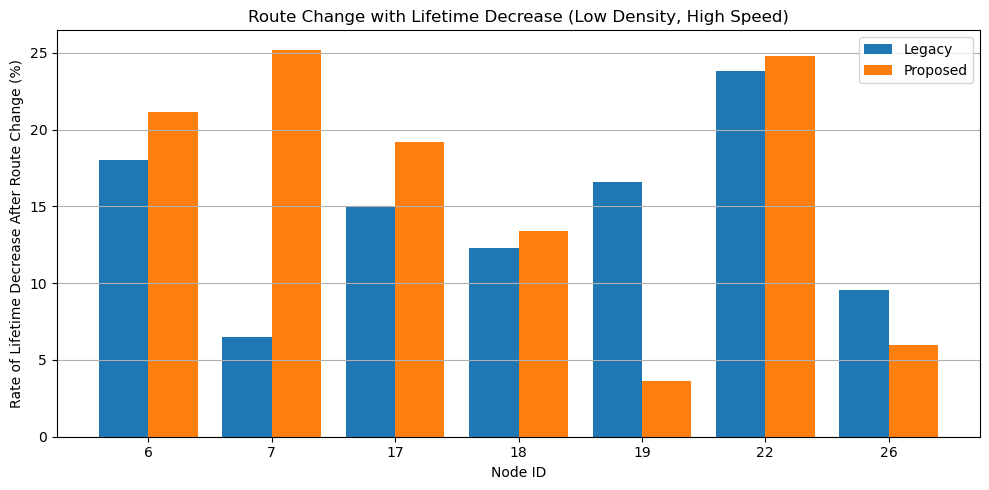

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

density_levels = ["고밀도", "중밀도", "저밀도"]
speed_levels = ["저속", "중속", "고속"]

density_map = {"고밀도": "High", "중밀도": "Medium", "저밀도": "Low"}
speed_map = {"저속": "Low", "중속": "Medium", "고속": "High"}

node_dict = {
    ("고밀도", "저속"): [0, 4, 6, 7, 9, 10, 11, 17, 19, 20],
    ("고밀도", "중속"): [0, 4, 6, 7, 9, 10, 11, 17, 19, 20],
    ("고밀도", "고속"): [0, 4, 6, 7, 9, 10, 11, 17, 19, 20],
    ("중밀도", "저속"): [6, 7, 17, 18, 21, 22, 24, 26, 27, 29],
    ("중밀도", "중속"): [6, 7, 17, 18, 21, 22, 24, 26, 27, 29],
    ("중밀도", "고속"): [6, 7, 17, 18, 21, 22, 24, 26, 27, 29],
    ("저밀도", "저속"): [6, 7, 17, 18, 19, 21, 22, 24, 25, 26],
    ("저밀도", "중속"): [6, 7, 17, 18, 19, 21, 22, 24, 25, 26],
    ("저밀도", "고속"): [6, 7, 17, 18, 19, 21, 22, 24, 25, 26],
}

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02"

def calc_lifetime_decrease_rate(path):
    try:
        df = pd.read_csv(path)
        df.columns = [
            "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
            "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
        ]
    except Exception:
        return None

    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["RouteChange"] = df["HopChange"] | df["NextHopChange"]
    df = df[df["RouteChange"]]

    if df.empty:
        return None

    decreased = df[df["New_LifeTime"] < df["Previous_LifeTime"]]
    rate = (len(decreased) / len(df)) * 100
    return rate

for density in density_levels:
    for speed in speed_levels:
        node_list = node_dict.get((density, speed), [])
        if not node_list:
            continue

        legacy_rates = []
        proposed_rates = []
        valid_nodes = []

        for node_id in node_list:
            legacy_path = os.path.join(base_path, density, speed, "기존", str(node_id), "aodv_routing_log.csv")
            proposed_path = os.path.join(base_path, density, speed, "제안", str(node_id), "aodv_routing_log.csv")

            if not os.path.exists(legacy_path) or not os.path.exists(proposed_path):
                continue

            legacy_rate = calc_lifetime_decrease_rate(legacy_path)
            proposed_rate = calc_lifetime_decrease_rate(proposed_path)

            if legacy_rate is None or proposed_rate is None:
                continue

            legacy_rates.append(legacy_rate)
            proposed_rates.append(proposed_rate)
            valid_nodes.append(node_id)

        if not valid_nodes:
            continue

        x = np.arange(len(valid_nodes))
        d_label = density_map[density]
        s_label = speed_map[speed]

        plt.figure(figsize=(10, 5))
        plt.bar(x - 0.2, legacy_rates, width=0.4, label='Legacy')
        plt.bar(x + 0.2, proposed_rates, width=0.4, label='Proposed')

        plt.xticks(x, [str(n) for n in valid_nodes])
        plt.xlabel("Node ID")
        plt.ylabel("Rate of Lifetime Decrease After Route Change (%)")
        plt.title(f"Route Change with Lifetime Decrease ({d_label} Density, {s_label} Speed)")
        plt.legend()
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()


[Error reading C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02\저밀도\고속\제안\26\aodv_routing_log.csv]: could not convert string to float: 'Time'


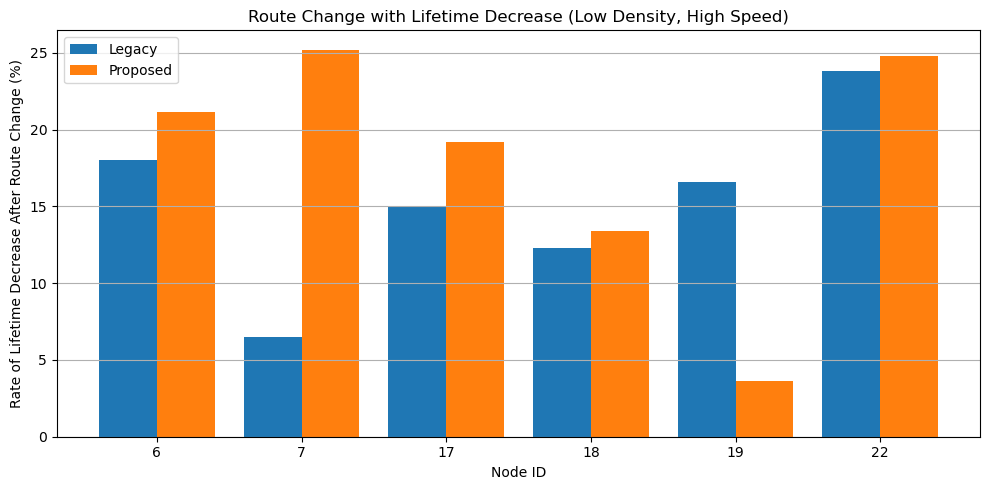

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02"
density = "저밀도"
speed = "고속"
node_list = [6, 7, 17, 18, 19, 21, 22, 24, 25, 26]

def calc_lifetime_decrease_rate(path):
    try:
        df = pd.read_csv(path, low_memory=False, dtype={
            "Time": float,
            "Previous_LifeTime": float,
            "New_LifeTime": float,
            "Previous_HopCount": float,
            "New_HopCount": float
        })
        df["Previous_HopCount"] = df["Previous_HopCount"].fillna(-1)
        df["New_HopCount"] = df["New_HopCount"].fillna(-1)
        df["Previous_NextHop"] = df["Previous_NextHop"].astype(str)
        df["New_NextHop"] = df["New_NextHop"].astype(str)
    except Exception as e:
        print(f"[Error reading {path}]: {e}")
        return None

    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["RouteChange"] = df["HopChange"] | df["NextHopChange"]
    df = df[df["RouteChange"]]

    if df.empty:
        return None

    decreased = df[df["New_LifeTime"] < df["Previous_LifeTime"]]
    rate = (len(decreased) / len(df)) * 100
    return rate

legacy_rates = []
proposed_rates = []
valid_nodes = []

for node_id in node_list:
    legacy_path = os.path.join(base_path, density, speed, "기존", str(node_id), "aodv_routing_log.csv")
    proposed_path = os.path.join(base_path, density, speed, "제안", str(node_id), "aodv_routing_log.csv")

    if not os.path.exists(legacy_path) or not os.path.exists(proposed_path):
        continue

    legacy_rate = calc_lifetime_decrease_rate(legacy_path)
    proposed_rate = calc_lifetime_decrease_rate(proposed_path)

    if legacy_rate is None or proposed_rate is None:
        continue

    legacy_rates.append(legacy_rate)
    proposed_rates.append(proposed_rate)
    valid_nodes.append(node_id)

if valid_nodes:
    x = np.arange(len(valid_nodes))
    plt.figure(figsize=(10, 5))
    plt.bar(x - 0.2, legacy_rates, width=0.4, label='Legacy')
    plt.bar(x + 0.2, proposed_rates, width=0.4, label='Proposed')
    plt.xticks(x, [str(n) for n in valid_nodes])
    plt.xlabel("Node ID")
    plt.ylabel("Rate of Lifetime Decrease After Route Change (%)")
    plt.title("Route Change with Lifetime Decrease (Low Density, High Speed)")
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("No valid data found.")


C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_37292\3119335207.py:32: DtypeWarning: Columns (0,3,4,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


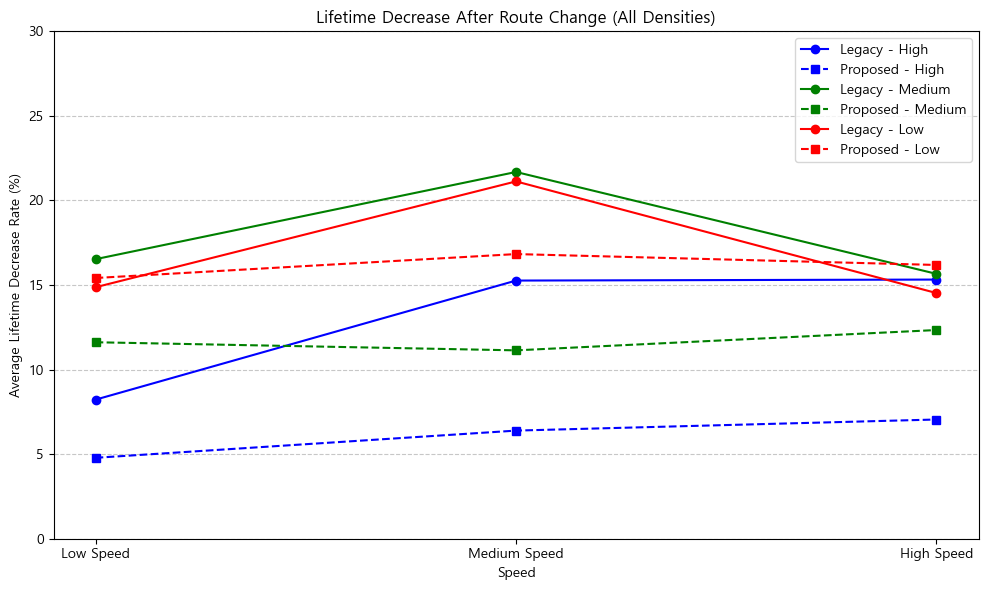

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

density_levels = ["고밀도", "중밀도", "저밀도"]
speed_levels = ["저속", "중속", "고속"]

density_map = {"고밀도": "High", "중밀도": "Medium", "저밀도": "Low"}
speed_map = {"저속": "Low", "중속": "Medium", "고속": "High"}
colors = {"고밀도": "blue", "중밀도": "green", "저밀도": "red"}

node_dict = {
    ("고밀도", "저속"): [0, 4, 6, 7, 9, 10, 11, 17, 19, 20],
    ("고밀도", "중속"): [0, 4, 6, 7, 9, 10, 11, 17, 19, 20],
    ("고밀도", "고속"): [0, 4, 6, 7, 9, 10, 11, 17, 19, 20],
    ("중밀도", "저속"): [6, 7, 17, 18, 21, 22, 24, 26, 27, 29],
    ("중밀도", "중속"): [6, 7, 17, 18, 21, 22, 24, 26, 27, 29],
    ("중밀도", "고속"): [6, 7, 17, 18, 21, 22, 24, 26, 27, 29],
    ("저밀도", "저속"): [6, 7, 17, 18, 19, 21, 22, 24, 25, 26],
    ("저밀도", "중속"): [6, 7, 17, 18, 19, 21, 22, 24, 25, 26],
    ("저밀도", "고속"): [6, 7, 17, 18, 19, 21, 22, 24, 25, 26],
}

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02"

def calc_lifetime_decrease_rate(path):
    try:
        df = pd.read_csv(path)
        df.columns = [
            "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
            "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
        ]
    except Exception:
        return None

    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["RouteChange"] = df["HopChange"] | df["NextHopChange"]
    df = df[df["RouteChange"]]

    if df.empty:
        return None

    decreased = df[df["New_LifeTime"] < df["Previous_LifeTime"]]
    rate = (len(decreased) / len(df)) * 100
    return rate

x_labels = [speed_map[s] + " Speed" for s in speed_levels]
x = np.arange(len(speed_levels))

fig, ax = plt.subplots(figsize=(10, 6))

for density in density_levels:
    legacy_avg = []
    proposed_avg = []

    for speed in speed_levels:
        node_list = node_dict.get((density, speed), [])
        if not node_list:
            legacy_avg.append(np.nan)
            proposed_avg.append(np.nan)
            continue

        legacy_rates = []
        proposed_rates = []

        for node_id in node_list:
            legacy_path = os.path.join(base_path, density, speed, "기존", str(node_id), "aodv_routing_log.csv")
            proposed_path = os.path.join(base_path, density, speed, "제안", str(node_id), "aodv_routing_log.csv")

            if not os.path.exists(legacy_path) or not os.path.exists(proposed_path):
                continue

            legacy_rate = calc_lifetime_decrease_rate(legacy_path)
            proposed_rate = calc_lifetime_decrease_rate(proposed_path)

            if legacy_rate is None or proposed_rate is None:
                continue

            legacy_rates.append(legacy_rate)
            proposed_rates.append(proposed_rate)

        legacy_avg.append(np.mean(legacy_rates) if legacy_rates else np.nan)
        proposed_avg.append(np.mean(proposed_rates) if proposed_rates else np.nan)

    color = colors[density]
    label_tag = density_map[density]
    ax.plot(x_labels, legacy_avg, marker='o', linestyle='-', color=color, label=f'Legacy - {label_tag}')
    ax.plot(x_labels, proposed_avg, marker='s', linestyle='--', color=color, label=f'Proposed - {label_tag}')

ax.set_xlabel("Speed")
ax.set_ylabel("Average Lifetime Decrease Rate (%)")
ax.set_title("Lifetime Decrease After Route Change (All Densities)")
ax.set_ylim(0, 30)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()


In [13]:
def draw_lifetime_decrease_graph(legacy_dict, proposed_dict):
    import matplotlib.pyplot as plt
    import numpy as np

    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False

    speed_labels = ["Low Speed", "Medium Speed", "High Speed"]
    density_map = {"고밀도": "High", "중밀도": "Medium", "저밀도": "Low"}
    colors = {"고밀도": "blue", "중밀도": "green", "저밀도": "red"}

    fig, ax = plt.subplots(figsize=(10, 6))

    for density in ["고밀도", "중밀도", "저밀도"]:
        legacy_avg = legacy_dict[density]
        proposed_avg = proposed_dict[density]
        color = colors[density]
        label_tag = density_map[density]

        ax.plot(speed_labels, legacy_avg, marker='o', linestyle='-', color=color, label=f'Legacy - {label_tag}')
        ax.plot(speed_labels, proposed_avg, marker='s', linestyle='--', color=color, label=f'Proposed - {label_tag}')

    ax.set_xlabel("Speed")
    ax.set_ylabel("Average Lifetime Decrease Rate (%)")
    ax.set_title("Lifetime Decrease After Route Change (All Densities)")
    ax.set_ylim(0, 30)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend()
    plt.tight_layout()
    plt.show()


C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_37292\1036553321.py:31: DtypeWarning: Columns (0,3,4,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


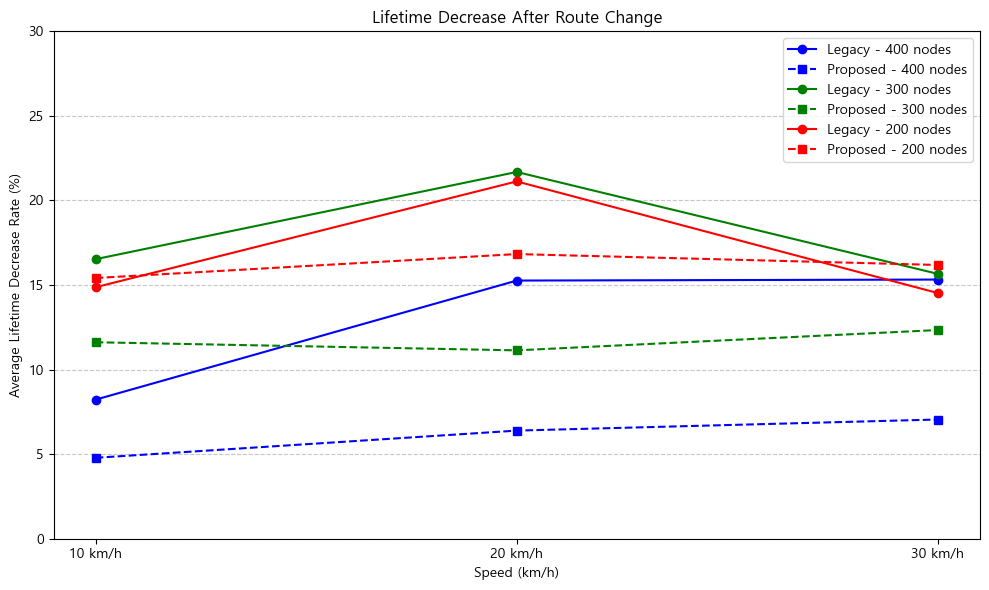

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

density_levels = ["고밀도", "중밀도", "저밀도"]
speed_levels = ["저속", "중속", "고속"]
density_map = {"고밀도": "High", "중밀도": "Medium", "저밀도": "Low"}
speed_map = {"저속": "Low", "중속": "Medium", "고속": "High"}
colors = {"고밀도": "blue", "중밀도": "green", "저밀도": "red"}

node_dict = {
    ("고밀도", "저속"): [0, 4, 6, 7, 9, 10, 11, 17, 19, 20],
    ("고밀도", "중속"): [0, 4, 6, 7, 9, 10, 11, 17, 19, 20],
    ("고밀도", "고속"): [0, 4, 6, 7, 9, 10, 11, 17, 19, 20],
    ("중밀도", "저속"): [6, 7, 17, 18, 21, 22, 24, 26, 27, 29],
    ("중밀도", "중속"): [6, 7, 17, 18, 21, 22, 24, 26, 27, 29],
    ("중밀도", "고속"): [6, 7, 17, 18, 21, 22, 24, 26, 27, 29],
    ("저밀도", "저속"): [6, 7, 17, 18, 19, 21, 22, 24, 25, 26],
    ("저밀도", "중속"): [6, 7, 17, 18, 19, 21, 22, 24, 25, 26],
    ("저밀도", "고속"): [6, 7, 17, 18, 19, 21, 22, 24, 25, 26],
}

base_path = r"C:\Users\Choe JongHyeon\Desktop\Applied Science\시뮬레이션 결과\Lifetime 결과_V02"

def calc_lifetime_decrease_rate(path):
    try:
        df = pd.read_csv(path)
        df.columns = [
            "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
            "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
        ]
    except Exception:
        return None

    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["RouteChange"] = df["HopChange"] | df["NextHopChange"]
    df = df[df["RouteChange"]]

    if df.empty:
        return None

    decreased = df[df["New_LifeTime"] < df["Previous_LifeTime"]]
    rate = (len(decreased) / len(df)) * 100
    return rate

legacy_avg_dict = {}
proposed_avg_dict = {}

for density in density_levels:
    legacy_avg = []
    proposed_avg = []

    for speed in speed_levels:
        node_list = node_dict.get((density, speed), [])
        if not node_list:
            legacy_avg.append(np.nan)
            proposed_avg.append(np.nan)
            continue

        legacy_rates = []
        proposed_rates = []

        for node_id in node_list:
            legacy_path = os.path.join(base_path, density, speed, "기존", str(node_id), "aodv_routing_log.csv")
            proposed_path = os.path.join(base_path, density, speed, "제안", str(node_id), "aodv_routing_log.csv")

            if not os.path.exists(legacy_path) or not os.path.exists(proposed_path):
                continue

            legacy_rate = calc_lifetime_decrease_rate(legacy_path)
            proposed_rate = calc_lifetime_decrease_rate(proposed_path)

            if legacy_rate is None or proposed_rate is None:
                continue

            legacy_rates.append(legacy_rate)
            proposed_rates.append(proposed_rate)

        legacy_avg.append(np.mean(legacy_rates) if legacy_rates else np.nan)
        proposed_avg.append(np.mean(proposed_rates) if proposed_rates else np.nan)

    legacy_avg_dict[density] = legacy_avg
    proposed_avg_dict[density] = proposed_avg

def draw_lifetime_decrease_graph(legacy_dict, proposed_dict):
    import matplotlib.pyplot as plt
    import numpy as np

    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False

    speed_labels = ["10 km/h", "20 km/h", "30 km/h"]

    density_info = {
        "고밀도": {"label": "400 nodes", "color": "blue"},
        "중밀도": {"label": "300 nodes", "color": "green"},
        "저밀도": {"label": "200 nodes", "color": "red"}
    }

    fig, ax = plt.subplots(figsize=(10, 6))

    for density in ["고밀도", "중밀도", "저밀도"]:
        legacy_avg = legacy_dict[density]
        proposed_avg = proposed_dict[density]
        info = density_info[density]
        label_nodes = info["label"]
        color = info["color"]

        ax.plot(speed_labels, legacy_avg, marker='o', linestyle='-', color=color,
                label=f'Legacy - {label_nodes}')
        ax.plot(speed_labels, proposed_avg, marker='s', linestyle='--', color=color,
                label=f'Proposed - {label_nodes}')

    ax.set_xlabel("Speed (km/h)")
    ax.set_ylabel("Average Lifetime Decrease Rate (%)")
    ax.set_title("Lifetime Decrease After Route Change")
    ax.set_ylim(0, 30)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend()
    plt.tight_layout()
    plt.show()


draw_lifetime_decrease_graph(legacy_avg_dict, proposed_avg_dict)
